# **LEGO Investment Analysis**

### **Introduction**

The goal of this project is to analyze LEGO sets from a **investment perspective**. The analysis includes data cleaning and preparation, exploratory data analysis (EDA), visualization, and interpretation of results. We will examine the price variability of LEGO sets over time, correlations between different set characteristics, and the average time needed to sell a set.

The data used in the project comes from a CSV file containing information about various LEGO sets, their prices, and sales numbers. Throughout the project, we will apply various data analysis and visualization techniques to better understand the trends and patterns present in the data.

<img src="LEGO_logo.png" alt="WHI" width="300"/>

### **Project Steps:**

1.	Importing necessary libraries and loading the data
2.	Data cleaning
3.	Exploratory data analysis (EDA)
4.	Rate of return
5.	Price variability analysis over time
6.	Correlation analysis
7.	Liquidity analysis

### **Libraries Used:**

- **pandas**, **numpy** - for data manipulation, cleaning, and numerical operations
- **matplotlib**, **seaborn** - for data visualization and creating insightful plots
- **scipy**, **statsmodels** - for statistical analysis and hypothesis testing
- **yfinance** - for fetching financial data, particularly useful if comparing LEGO set performance with other assets
- **pathlib** - for creating file paths

In [8434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import yfinance as yf
import statsmodels.api as sm
from pandas_datareader import data as pdr

#### **Paths and data**

In [8435]:
# Paths for easier management
csv_path = Path() / "csv"
plots_path = Path() / "plots"

In [8436]:
# Read all csv files
df = pd.read_csv(csv_path / 'lego_to_be_cleaned.csv', )
timeseries = pd.read_csv(csv_path / 'time_series.csv', sep=";")
liquidity = pd.read_csv(csv_path /'liquidity.csv', sep=";") 

In [8437]:
df.head(2)

,Number,Name,Theme,Subtheme,Year,Pieces,Minifigs,Availability,Retired,ReleasedDate,...,Retail,Paid,Value,Growth,Condition,Date,Notes,Collection,Status,URL
0,75144-1,Snowspeeder,Star Wars,Ultimate Collector Series,2017,1703,2,Exclusive,True,05/05/2017,...,199;99 €,199;99 €,330;40 €,65.21,New,NaN,NaN,Default,Owned,https://www.brickeconomy.com/set/75144-1/lego-...
1,10251-1,Brick Bank,Icons,Modular Buildings,2016,2380,6,RetailLimited,True,02/01/2016,...,149;99 €,149;99 €,494;81 €,229.89,New,NaN,NaN,Default,Owned,https://www.brickeconomy.com/set/10251-1/lego-...


#### **Data cleaning**

The data in the dataframe is in a barely readable format - some columns have missing values, column names start with capital letters (which may hinder syntax), there are no spaces in the column names, and monetary values are improperly formatted. 


**It’s time to change that!!!**

In [8438]:
# Delete all not wanted columns
df = df.drop(['Subtheme', 'Paid', 'Growth', 'Condition', 'Date', 'Notes', 'Collection', 'Status', 'URL'], axis='columns')

In [8439]:
# All column names should start with a lowerletter and have '_' where space is required
df.columns = [col.lower() for col in df.columns]
df.rename(columns={'releaseddate': 'released_date', 'retireddate': 'retired_date'}, inplace=True)

df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,05/05/2017,15/01/2019,199;99 €,330;40 €
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,02/01/2016,14/11/2018,149;99 €,494;81 €
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,01/08/2016,03/12/2020,89;99 €,113;14 €
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,02/07/2016,25/11/2018,219;99 €,327;12 €
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,02/01/2016,24/11/2017,24;99 €,30;14 €


In [8440]:
# Checking for ‘NaN’ - empty cells in columns
print(df.isnull().sum())

# Counting the number of rows with missing values
num_rows_with_nan = df[df.isnull().any(axis=1)].shape[0]
print(f'\nNumber of rows with at least one NaN value: {num_rows_with_nan}.')

number            0
name              1
theme             0
year              0
pieces            0
minifigs          0
availability      0
retired           0
released_date    19
retired_date     15
retail            0
value             0
dtype: int64

Number of rows with at least one NaN value: 35.


In [8441]:
# Function to clean and convert currency values
def clean_currency(value):
    try:
        # Remove the currency symbol and replace ';' with '.'
        value = value.replace('€', '').replace(';', '.').strip()
        # Convert to float
        return float(value)
    except ValueError:
        # Return None if conversion is not possible
        return None

# Apply the function to the 'retail' and 'value' columns
df['retail'] = df['retail'].apply(clean_currency)
df['value'] = df['value'].apply(clean_currency)

# Drop rows where conversion to float was not possible
df = df.dropna(subset=['retail', 'value']).reset_index(drop=True)

df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,05/05/2017,15/01/2019,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,02/01/2016,14/11/2018,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,01/08/2016,03/12/2020,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,02/07/2016,25/11/2018,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,02/01/2016,24/11/2017,24.99,30.14


In [8442]:
# Function to convert date format and handle invalid dates
def convert_date_format(date_str):
    try:
        return pd.to_datetime(date_str)
    except ValueError:
        return pd.NaT

# Apply the function to the date columns using .loc to avoid the SettingWithCopyWarning
df.loc[:, 'released_date'] = df['released_date'].apply(convert_date_format)
df.loc[:, 'retired_date'] = df['retired_date'].apply(convert_date_format)

# Remove rows with invalid dates
df = df.dropna(subset=['released_date', 'retired_date']).reset_index(drop=True)

df.head()

/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/831832553.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-02-01 00:00:00,2018-11-14 00:00:00,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-01-08 00:00:00,2020-03-12 00:00:00,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-02-07 00:00:00,2018-11-25 00:00:00,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-02-01 00:00:00,2017-11-24 00:00:00,24.99,30.14


In [8443]:
# Checking for duplicates in the data
duplicates_num = df.duplicated().sum()

# Removing duplicates if they exist
if duplicates_num == 0:
    print('There are no duplicates in the data.')
else:
    print(f'There are {duplicates_num} duplicates in the data.')
    duplicates = df[df.duplicated(keep=False)]
    print('\nDuplicates:')
    print(duplicates)
    
    df = df.drop_duplicates()
    print(f'\nDuplicates have been removed. The cleaned data now has {df.shape[0]} rows.')

There are 5 duplicates in the data.

Duplicates:
       number              name         theme  year  pieces  minifigs  \
8818   8748-1  Rhotuka Spinners      Bionicle  2005       5         0   
8819   8748-1  Rhotuka Spinners      Bionicle  2005       5         0   
11408   210-2   Small Store Set  System i Leg  1958      30         0   
11409   210-2   Small Store Set  System i Leg  1958      30         0   
11421   226-1     8 Named Beams  System i Leg  1958       8         0   
11422   226-1     8 Named Beams  System i Leg  1958       8         0   
11440   259-1    1:87 VW Pickup  System i Leg  1958       0         0   
11441   259-1    1:87 VW Pickup  System i Leg  1958       0         0   
11447   308-3      Fire Station  System i Leg  1958     111         0   
11448   308-3      Fire Station  System i Leg  1958     111         0   

      availability  retired        released_date         retired_date  retail  \
8818        Retail     True  2005-01-01 00:00:00  2007-01-01 00:00

In [8444]:
df.reset_index(drop=True)
df.to_csv(csv_path / 'lego.csv')
df

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-02-01 00:00:00,2018-11-14 00:00:00,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-01-08 00:00:00,2020-03-12 00:00:00,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-02-07 00:00:00,2018-11-25 00:00:00,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-02-01 00:00:00,2017-11-24 00:00:00,24.99,30.14
...,...,...,...,...,...,...,...,...,...,...,...,...
17305,662403-1,Zombie with Burning Baby Zombie and TNT,Minecraft,2024,12,2,Promotional,True,2024-01-01 00:00:00,2024-01-02 00:00:00,0.00,4.73
17306,9790-1,ROBOLAB Team Challenge Set,Education,1999,725,0,Retail,True,1999-01-01 00:00:00,2001-01-01 00:00:00,175.99,193.78
17307,2000443-1,Workshop Kit Freewheeler,Education,2015,82,1,RetailLimited,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,11.00
17308,2000442-1,Workshop Kit Spinning Top,Education,2015,10,0,Retail,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,23.77


The above transformations allowed for a more accurate data format. Data saved as 'lego.csv'.

### **Exploratory data analysis (EDA)**

#### Distribution

In [8445]:
# Select numerical columns
numerical_columns = ['pieces', 'minifigs', 'retail', 'value']

# Get basic statistics
basic_stats = df[numerical_columns].describe()
basic_stats

,pieces,minifigs,retail,value
count,17305.000000,17305.000000,17305.000000,17305.000000
mean,201.286102,1.378792,23.596741,82.716292
std,453.393221,2.556618,43.614355,133.294443
min,0.000000,0.000000,0.000000,-0.880000
25%,8.000000,0.000000,3.070000,11.250000
50%,50.000000,1.000000,9.990000,31.220000
75%,209.000000,2.000000,26.390000,89.350000
max,11695.000000,60.000000,849.990000,998.310000


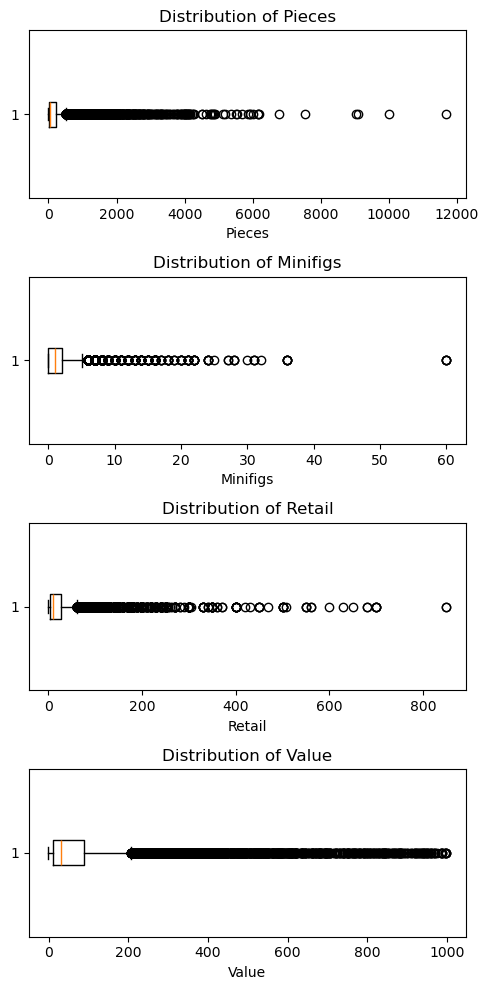

In [8446]:
# Create subplots for each numerical column
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(5, 10))

# Plot boxplots for each numerical column
for i, col in enumerate(numerical_columns):
    axes[i].boxplot(df[col].dropna(), vert=False)
    axes[i].set_title(f'Distribution of {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())

plt.tight_layout()
plt.savefig(plots_path / 'boxplots_features.pdf')
plt.show()

The analysis of the LEGO dataset through boxplots reveals several key insights about the characteristics of the sets. There are significant outliers in each category, indicating the presence of a few sets that are notably large, include many minifigures, have high retail prices, or have appreciated significantly in value.

These outliers suggest that certain sets, possibly due to their complexity or other special features, stand out from the majority. This variability provides a rich area for further exploration to understand what drives these exceptional cases, such as specific themes, editions, or unique characteristics that contribute to their higher pieces, prices, and values.

In summary, while most LEGO sets fall within a predictable range for pieces, minifigures, retail prices, and current values, the existence of high-value outliers points to special sets that may hold particular interest for collectors and enthusiasts. This balance between consistency and notable exceptions shapes the overall landscape of the LEGO market.

#### Average set price and availability status

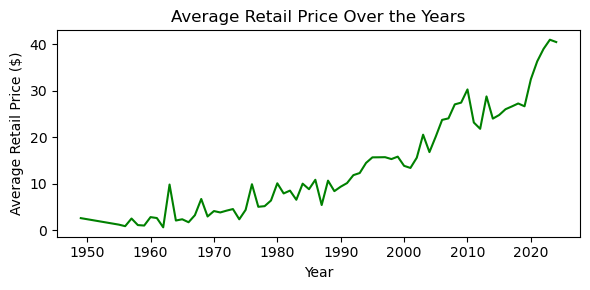

In [8447]:
# Line plot of average retail price over the years
avg_price_per_year = df.groupby('year')['retail'].mean()
plt.figure(figsize=(6, 3))
avg_price_per_year.plot(kind='line', color='green')
plt.title('Average Retail Price Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Retail Price ($)')
plt.tight_layout()
plt.savefig(plots_path / 'average_retail.pdf')
plt.show()

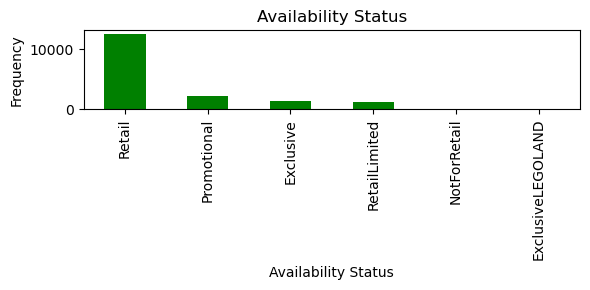

In [8448]:
# Bar plot of availability status
availability_counts = df['availability'].value_counts()
plt.figure(figsize=(6, 3))
availability_counts.plot(kind='bar', color='green')
plt.title('Availability Status')
plt.xlabel('Availability Status')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(plots_path / 'availability_status.pdf')
plt.show()

In [8449]:
availability_counts

availability
Retail               12514
Promotional           2231
Exclusive             1421
RetailLimited         1104
NotForRetail            24
ExclusiveLEGOLAND       11
Name: count, dtype: int64

The vast majority of LEGO sets fall under the retail category, indicating a strategy focused on wide availability and accessibility. Promotional, exclusive, and retail limited sets, while fewer in number, play a significant role in creating diversity and appealing to collectors through limited availability and special releases. Sets categorized as Not For Retail and Exclusive LEGOLAND are rare, highlighting unique opportunities for collectors seeking highly specific or location-based sets.

#### Number of released sets each year

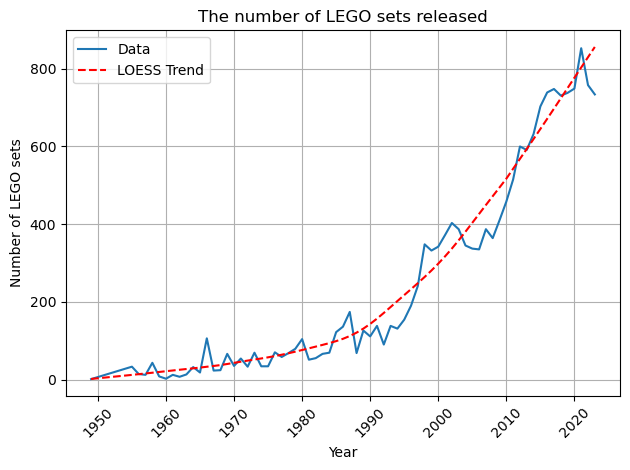

In [8450]:
# Number of sets released per year
sets_by_year = df.groupby("year").size().reset_index(name="number")

# Plot actual data
plt.plot(sets_by_year["year"][:-1], sets_by_year["number"][:-1], label="Data")

# Add a LOESS trend line
lowess = sm.nonparametric.lowess
loess_smoothed = lowess(sets_by_year["number"][:-1], sets_by_year["year"][:-1], frac=0.4)  # frac is the smoothing parameter
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], linestyle="--", label="LOESS Trend", color='r')

# Configure plot
plt.legend()
plt.title('The number of LEGO sets released')
plt.xlabel("Year")
plt.ylabel("Number of LEGO sets")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_path / 'year_over_year_number_of_sets.pdf')
plt.show()

In [8451]:
# Sets released per year (table)
# The year 2024 is not included in the table because it has not yet ended.
sets_by_year_table = df.groupby("year").count()
sets_by_year_table["number"][:-1]

year
1949      1
1955     33
1956     14
1957     12
1958     43
       ... 
2019    738
2020    749
2021    853
2022    758
2023    734
Name: number, Length: 70, dtype: int64

The above chart depicts the number of LEGO sets released over the years. The blue line illustrates the actual number of sets released each year, while the red dashed line represents the LOESS trend (Locally Estimated Scatterplot Smoothing), which is a technique for smoothing data.

**Observations:**

1. **Increase in the number of sets**: Since 1950, the number of LEGO sets released has been steadily increasing, indicating the growing popularity and expansion of the LEGO company.
2. **Acceleration in the 1990s**: In the 1990s, there is a significant acceleration in the rate of new set releases, which may be related to the expansion of the product range and the introduction of new series and themes.
3. **Stabilization and further growth**: After the year 2000, the number of new sets continues to grow, although at a somewhat more stable rate. The red LOESS trend line shows the overall upward trend with certain periods of acceleration and stabilization.

The analysis of the chart suggests that LEGO has been systematically increasing its product offering, which may be related to the growing demand for diverse sets as well as the development of new technologies and materials that allow for the creation of more advanced and varied products.

#### Complexity

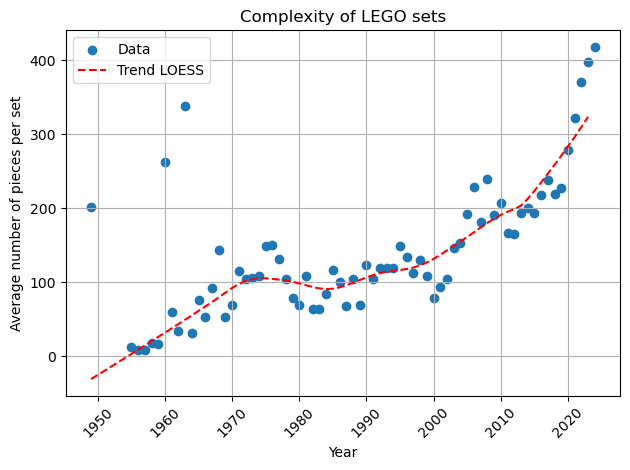

In [8452]:
# Complexity trend in LEGO sets per year
# Group the data by year and calculate the average number of parts per set
parts_per_set = df.groupby('year')['pieces'].mean()

# Create a scatter plot of the data
plt.scatter(parts_per_set.index, parts_per_set.values, label="Data")

# Add a LOESS trend line
lowess = sm.nonparametric.lowess
loess_smoothed = lowess(parts_per_set.values[:-1], parts_per_set.index[:-1], frac=0.3)  # frac is the smoothing parameter
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], 'r--', label="Trend LOESS")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.title('Complexity of LEGO sets')
plt.xlabel('Year')
plt.ylabel('Average number of pieces per set')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_path / 'year_over_year_complexity_of_sets.pdf')
plt.show()

The above chart illustrates the complexity of LEGO sets over the years, measured by the average number of pieces per set. The blue dots represent the actual data points for each year, while the red dashed line represents the LOESS trend.

The analysis of the chart suggests that LEGO sets have become increasingly complex over the years. This trend reflects the company's evolution in set design, incorporating more pieces to create intricate and detailed models. The sharp increase in recent years highlights LEGO's response to market demand for more sophisticated and elaborate sets of the older clientele (adults).

#### Most popular themes

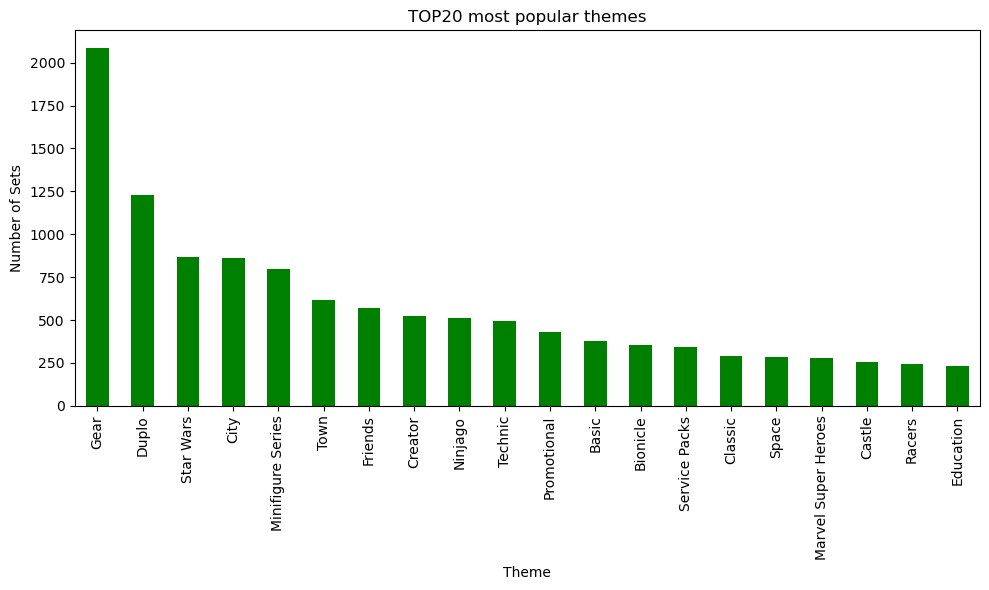

In [8453]:
# Counting the number of sets for each theme
theme_counts = df['theme'].value_counts().head(20)

# Plotting the number of sets for each theme
plt.figure(figsize=(10, 6))
theme_counts.plot(kind='bar', color='green')
plt.xlabel('Theme')
plt.ylabel('Number of Sets')
plt.title('TOP20 most popular themes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(plots_path / 'most_popular_themes.pdf')
plt.show()

In [8454]:
theme_counts

theme
Gear                   2084
Duplo                  1226
Star Wars               866
City                    862
Minifigure Series       798
Town                    618
Friends                 570
Creator                 523
Ninjago                 513
Technic                 494
Promotional             430
Basic                   379
Bionicle                357
Service Packs           344
Classic                 292
Space                   287
Marvel Super Heroes     280
Castle                  256
Racers                  246
Education               232
Name: count, dtype: int64

The data highlights the diverse range of LEGO themes and their popularity. Themes like Gear, Duplo, and Star Wars dominate the number of sets available, reflecting their broad appeal and market demand. Each theme caters to different interests and age groups, showcasing LEGO’s strategy to appeal to a wide audience through various themes and product lines.

### **Rate of Return Analysis**

The rate of return can be analyzed using various indicators. In this study, the Holding Period Return (HPR) and the Annualized Percentage Return (APR) were utilized. Both indicators allow for the assessment of the total return on investment. HPR shows the rate of return over the entire investment period, while APR determines the average annual return. This makes APR a useful indicator for comparing investments with different time horizons as well as between various instruments.

#### **Holding Period Return (HPR)**
The Holding Period Return (HPR) is defined as:

$$
\text{HPR} = \frac{P_t - P_0}{P_0}
$$

where:
- **HPR** - Holding Period Return,
- **P_t** - final value of the investment,
- **P_0** - initial value of the investment.

#### **Annualized Percentage Return (APR)**
The Annualized Percentage Return (APR) is calculated as:

$$
\text{APR} = \left( \text{HPR} \right)^{\frac{1}{n}} - 1
$$

where:
- **HPR** - Holding Period Return,
- **n** - duration of the investment in years.

#### **Applied Filters in the Project:**

To ensure the quality and relevance of the data, several filters were applied to the dataset. These filters help to refine the dataset by excluding entries that do not meet specific criteria. Below are the details of each filter applied:

- **Pieces Filter**: This filter removes any LEGO sets that do not contain any pieces. Sets with zero pieces are likely incomplete entries or are a different type of product (not a LEGO set but for example, a keychain, etc.) and are not useful for analyzing the complexity or value of LEGO sets.

- **Retail Price Filter**: This filter excludes LEGO sets that do not have a retail price. Sets with a retail price of zero are also likely errors or special cases (e.g., promotional items) that do not represent the typical retail market.

- **Retired Date Filter**: This filter removes any LEGO sets that were retired before December 31, 1989 and after December 31, 2022. The purpose of this filter is to focus on more recent LEGO sets, which are more likely to be relevant for the comparison. This helps in eliminating older sets that might have different characteristics and to focus on sets that have been fully retired, ensuring that the analysis considers only those sets for which complete market data is available. This helps in making accurate comparisons and assessments.

In [8455]:
# Filer database
df = df[(df['pieces'] != 0)]
df = df[(df['retail'] != 0)]
date_min = pd.Timestamp('1989-12-31')
date_max = pd.Timestamp('2022-12-31')
df = df[df['retired_date'] >= date_min]
df = df[df['retired_date'] <= date_max]

# Reset index
df = df.reset_index(drop=True)

In [8456]:
# Create new columns (HPR, APR)
df['HPR'] = (df['value'] - df['retail']) / df['retail']
df['APR'] = ((df['HPR'] + 1) ** (1/(2024 - df['year']))) - 1

df.head(3)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40,0.652083,0.074354
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-02-01 00:00:00,2018-11-14 00:00:00,149.99,494.81,2.298953,0.160906
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-01-08 00:00:00,2020-03-12 00:00:00,89.99,113.14,0.257251,0.029029


In [8457]:
# Average APR per year
APR_yearly = df.groupby("year").mean('APR')
print(APR_yearly['APR'].tail())

year
2018    0.085203
2019    0.078279
2020    0.088725
2021    0.114152
2022    0.213303
Name: APR, dtype: float64


In [8458]:
# Average APR of all sets
APR_mean = round(df['APR'].mean(), 6)
print(f'Average APR value for all sets is equal {APR_mean}')

Average APR value for all sets is equal 0.083529


In [8459]:
# Average APR per set theme
APR_by_themes = df.groupby("theme").mean('APR')
APR_by_themes = APR_by_themes.sort_values("APR", ascending=False)
APR_by_themes['APR']

theme
FORMA                        0.379361
BrickLink                    0.327697
BrickHeadz                   0.198936
Avatar The Last Airbender    0.183646
Mixels                       0.161662
                               ...   
Unikitty!                    0.021246
Mindstorms                   0.021110
DC Super Hero Girls          0.012488
Trolls World Tour            0.003972
LEGO Art                     0.002212
Name: APR, Length: 139, dtype: float64

#### **APR and size**

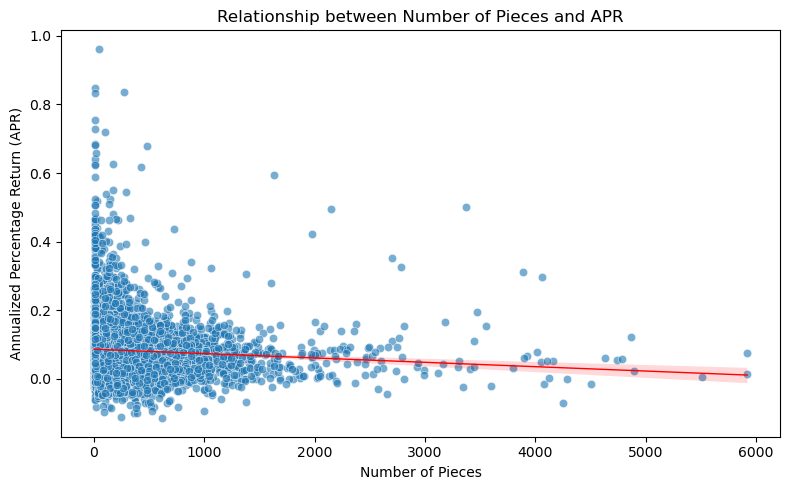

In [8460]:
# Create a scatter plot with a trend line
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='pieces', y='APR', alpha=0.6)
sns.regplot(data=df, x='pieces', y='APR', scatter=False, color='red', line_kws={"lw":1})

# Add labels and title
plt.xlabel('Number of Pieces')
plt.ylabel('Annualized Percentage Return (APR)')
plt.title('Relationship between Number of Pieces and APR')
plt.tight_layout()
plt.savefig(plots_path / 'relationship_pieces_apr.pdf')
plt.show()

/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/1260814050.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('group')['APR'].mean()


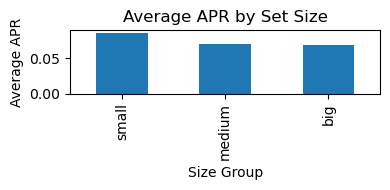

group
small     0.086
medium    0.071
big       0.069
Name: APR, dtype: float64

In [8461]:
df['group'] = pd.cut(df['pieces'], bins=[0, 500, 1000, float('inf')], labels=['small', 'medium', 'big'])

# Calculate the average annual return for each size group
grouped = df.groupby('group')['APR'].mean()

# Plot the average APR for each size group
plt.figure(figsize=(4, 2))
grouped.plot(kind='bar')
plt.title('Average APR by Set Size')
plt.xlabel('Size Group')
plt.ylabel('Average APR')
plt.tight_layout()
plt.savefig(plots_path / 'set_size_group.pdf')
plt.show()

# Display the grouped APR values
round(grouped, 3)

Although the analysis showed that small sets are the most profitable, the differences are negligible. It can be concluded that the size of the set does not significantly impact the APR.

#### Highest/lowest APR

In [8462]:
# Highest APR values
df.sort_values("APR", ascending=False).head(3)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
8691,853922-1,Creative Rings,Friends,2019,43,0,ExclusiveLEGOLAND,True,2019-01-01 00:00:00,2021-01-01 00:00:00,7.91,229.92,28.067004,0.961914,small
9604,43108-4,Dragon Guitarist,Vidiyo,2021,13,1,Retail,True,2021-01-11 00:00:00,2021-01-12 00:00:00,4.99,31.41,5.294589,0.846386,small
9091,77902-1,Captain Marvel and the Asis,Marvel Super Heroes,2019,271,2,Retail,True,2019-07-20 00:00:00,2019-07-20 00:00:00,39.60,826.53,19.871970,0.836169,small


In [8463]:
# Lowest APR values
df.sort_values("APR", ascending=True).head(3)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
9501,43114-1,Punk Pirate Ship,Vidiyo,2021,615,3,Retail,True,2021-01-06 00:00:00,2022-04-23 00:00:00,69.99,48.58,-0.305901,-0.114598,medium
9406,43185-1,Boun's Boat,Disney,2021,247,2,Retail,True,2021-01-03 00:00:00,2022-05-02 00:00:00,49.99,35.28,-0.294259,-0.109675,small
9499,43112-1,Robo HipHop Car,Vidiyo,2021,387,2,Retail,True,2021-01-06 00:00:00,2022-10-06 00:00:00,29.99,21.99,-0.266756,-0.098257,small


In [8464]:
# Highest HPR values
df.sort_values("HPR", ascending=False).head(3)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
4967,1620-1,Astro Dart,Space,1989,30,1,RetailLimited,True,1989-01-01 00:00:00,1991-01-01 00:00:00,2.19,581.68,264.607306,0.172908,small
3685,3347-1,One Minifig Pack Rock Raiders #1,Rock Raiders,2000,8,1,Exclusive,True,2000-01-01 00:00:00,2002-01-01 00:00:00,1.75,437.65,249.085714,0.258695,small
4760,1695-1,Treasure Chest,Castle,1992,23,1,Retail,True,1992-01-01 00:00:00,1994-01-01 00:00:00,1.75,396.06,225.320000,0.184636,small


In [8465]:
# Lowest HPR values
df.sort_values("HPR", ascending=True).head(3)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
767,71170-1,Starter Pack PS3,Dimensions,2015,269,0,Retail,True,2015-09-29 00:00:00,2017-12-28 00:00:00,99.99,59.07,-0.409241,-0.056806,small
8316,75951-1,Grindelwald's Escape,Harry Potter,2018,132,2,Retail,True,2018-08-24 00:00:00,2020-02-23 00:00:00,29.99,17.80,-0.406469,-0.083272,small
8274,41775-8,Camouflage Unikitty,Unikitty!,2018,14,1,Retail,True,2018-01-06 00:00:00,2018-12-31 00:00:00,3.99,2.38,-0.403509,-0.082511,small


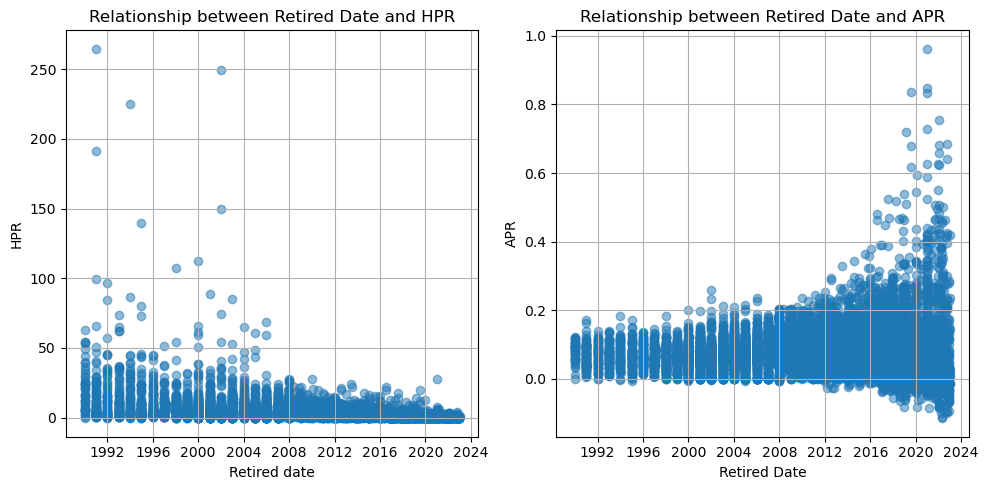

In [8466]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot of Pieces vs. HPR
axes[0].scatter(df['retired_date'], df['HPR'], alpha=0.5)
axes[0].set_title('Relationship between Retired Date and HPR')
axes[0].set_xlabel('Retired date')
axes[0].set_ylabel('HPR')
axes[0].grid(True)

# Scatter plot of Retired Date vs. APR
axes[1].scatter(df['retired_date'], df['APR'], alpha=0.5)
axes[1].set_title('Relationship between Retired Date and APR')
axes[1].set_xlabel('Retired Date')
axes[1].set_ylabel('APR')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(plots_path / 'retired_date_apr_hpr.pdf')
plt.show()

- Older Sets: Investing in sets retired before 2000 can yield higher HPR, particularly if they are rare and highly collectible.
- Recent Retirements: Sets retired after 2010 show a wider range of APR values, indicating potential for high returns but also greater risk. Investors should consider specific characteristics of these sets to identify potential high-return investments.
- Age and Value: The inverse relationship between retired date and HPR suggests that older sets tend to appreciate more significantly over time due to their rarity and collectible status.
- Recent Market Trends: The increasing APR for recently retired sets may reflect LEGO’s strategy of producing more desirable and collectible sets in recent years, possibly influenced by market trends and consumer demand.

#### **Comparison to other assets**

[*********************100%%**********************]  3 of 3 completed
/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/2813881306.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  other_instruments = other_instruments.resample('M').last()


,BTC-USD,DAX,SP500,Gold
Date,,,,
2023-08-31,25931.472656,15947.080078,4507.660156,1940.095
2023-09-30,26967.916016,15386.580078,4288.049805,1848.490
2023-10-31,34667.781250,14810.339844,4193.799805,1984.650
2023-11-30,37712.746094,16215.429688,4567.799805,2036.195
2023-12-31,42156.902344,16751.640625,4769.830078,2063.235


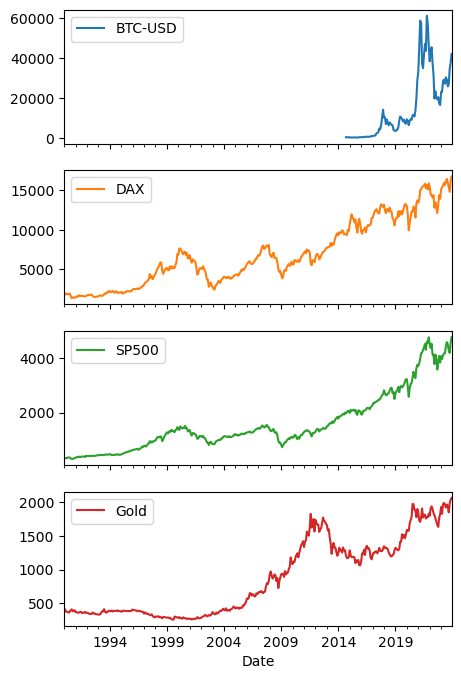

In [8467]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["^GSPC", "^GDAXI", "BTC-USD"], start="1990-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments = other_instruments.rename(columns={'^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX'})
gold_historical_data = pd.read_csv(csv_path / 'xauusd.csv')
other_instruments = other_instruments.reset_index()
other_instruments = other_instruments.join(gold_historical_data['Close'])
other_instruments = other_instruments.rename(columns={'Close': 'Gold'})

#Set 'Date' as index
other_instruments.set_index("Date", inplace=True)
other_instruments.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path / 'long_time_series_all.pdf')

other_instruments.tail()

In [8468]:
HPR_SP500 = (((other_instruments['SP500'].iloc[-1] - other_instruments['SP500'].iloc[0]) / other_instruments['SP500'].iloc[0]))
APR_SP500 = round(((HPR_SP500 + 1) ** (1/34)) - 1, 6)

HPR_DAX = (((other_instruments['DAX'].iloc[-1] - other_instruments['DAX'].iloc[0]) / other_instruments['DAX'].iloc[0]))
APR_DAX = round(((HPR_DAX + 1) ** (1/34)) - 1, 6)

HPR_Gold = (((other_instruments['Gold'].iloc[-1] - other_instruments['Gold'].iloc[0]) / other_instruments['Gold'].iloc[0]))
APR_Gold = round(((HPR_Gold + 1) ** (1/34)) - 1, 6)

HPR_BTC = ((other_instruments['BTC-USD'].iloc[-1] - other_instruments['BTC-USD'].iloc[300]) / other_instruments['BTC-USD'].iloc[300])
APR_BTC = round(((HPR_BTC + 1) ** (1/9)) - 1, 6)

APR_lego_1990 = round(df.loc[df['year'].isin(np.arange(1990, 2025, 1)), 'APR'].mean(), 6)

In [8469]:
print(f'APR for SP500: {APR_SP500}')
print(f'APR for DAX: {APR_DAX}')
print(f'APR for Gold: {APR_Gold}')
print(f'APR for BTC: {APR_BTC}')
print(f'APR for LEGO: {APR_lego_1990}')

APR for SP500: 0.081815
APR for DAX: 0.067441
APR for Gold: 0.048092
APR for BTC: 0.795414
APR for LEGO: 0.083724


The APR for LEGO is competitive compared to traditional stock indices like SP500 and DAX and significantly higher than Gold. This makes LEGO an attractive alternative investment, especially for those interested in collectibles.

In [8470]:
# Transforming columns with dates into date format
df['released_date'] = pd.to_datetime(df['released_date'])
df['retired_date'] = pd.to_datetime(df['retired_date'])

# Extracting the month from release and retirement dates
df['released_month'] = df['released_date'].dt.month
df['retired_month'] = df['retired_date'].dt.month

# Grouping data by release and retirement months
release_monthly = df['released_month'].value_counts().sort_index()
retire_monthly = df['retired_month'].value_counts().sort_index()

In [8471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689 entries, 0 to 9688
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   number          9689 non-null   object        
 1   name            9688 non-null   object        
 2   theme           9689 non-null   object        
 3   year            9689 non-null   int64         
 4   pieces          9689 non-null   int64         
 5   minifigs        9689 non-null   int64         
 6   availability    9689 non-null   object        
 7   retired         9689 non-null   bool          
 8   released_date   9689 non-null   datetime64[ns]
 9   retired_date    9689 non-null   datetime64[ns]
 10  retail          9689 non-null   float64       
 11  value           9689 non-null   float64       
 12  HPR             9689 non-null   float64       
 13  APR             9689 non-null   float64       
 14  group           9689 non-null   category      
 15  rele

#### **Time on a market**

In [8472]:
# Calculating the time on the market in days
df['time_on_market'] = (df['retired_date'] - df['released_date']).dt.days

# Calculating the time on the market
average_time_on_market = df['time_on_market'].mean()
max_time_on_market = df['time_on_market'].max()

print(f'Average time on a market is usually around {round(average_time_on_market, 0)} days with the maximum of {round(max_time_on_market, 0)} days')

Average time on a market is usually around 597.0 days with the maximum of 4713 days


In [8473]:
timeseries.head()

,set_num,name_sets,year,theme_id,num_parts,name_themes,retail_price,sty.21,lut.21,mar.21,...,mar.23,kwi.23,maj.23,cze.23,lip.23,sie.23,wrz.23,paź.23,lis.23,gru.23
0,5289-1,Toggle Joints & Connectors,1996,453,64,Technic,3.95,9.30,8.87,9.34,...,9.31,8.08,7.91,6.83,8.43,7.91,6.32,8.13,7.91,7.01
1,7121-1,Naboo Swamp,1999,158,82,Star Wars,8.79,60.92,56.85,56.33,...,72.70,58.29,71.98,91.15,79.82,70.74,85.92,91.52,71.70,66.79
2,7111-1,Droid Fighter,1999,158,62,Star Wars,5.27,28.77,27.33,32.72,...,46.50,54.41,42.72,48.57,42.17,56.06,47.54,41.01,50.64,39.90
3,7171-1,Mos Espa Podrace,1999,158,907,Star Wars,79.19,275.43,327.97,367.35,...,333.09,304.65,323.50,339.89,334.51,433.46,367.34,431.05,375.69,349.02
4,7104-1,Desert Skiff,2000,158,55,Star Wars,5.27,66.64,46.98,62.45,...,64.62,62.74,68.10,77.60,66.18,64.22,79.69,74.27,65.38,59.95


In [8474]:
timeseries = timeseries.dropna(subset=['retail_price'])
timeseries = timeseries.reset_index(drop=True)
timeseries = timeseries.sort_values(by='year')
timeseries = timeseries.replace(',', '.')

In [8475]:
average_values = timeseries.iloc[:, 8:].apply(lambda x: x.mean(), axis=0)
average_values_list = average_values.tolist()

average_values_rounded = [round(x, 6) for x in average_values_list]

average_values_rounded_series = pd.Series(average_values_rounded, name='average_values_rounded')
average_values_rounded_series.name = 'average_values_rounded'
timeseries['average_values_rounded'] = average_values_rounded_series

LEGO_basket = pd.DataFrame(average_values_rounded_series)

[*********************100%%**********************]  4 of 4 completed
/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/1777181478.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  other_instruments = other_instruments.resample('M').last()


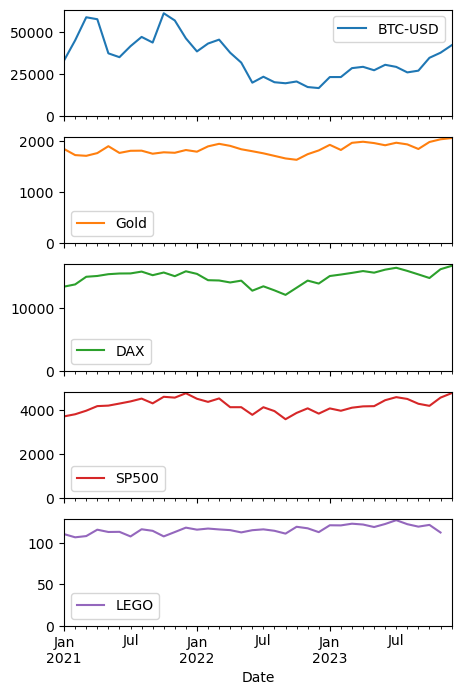

In [8476]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["GC=F", "^GSPC", "^GDAXI", "BTC-USD"], start="2021-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments = other_instruments.reset_index()

# Merge LEGO_basket and other_investments
all_instruments = pd.concat([other_instruments, LEGO_basket], axis=1)
all_instruments= all_instruments.rename(columns={'GC=F': 'Gold', '^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX','average_values_rounded': 'LEGO'})

# Set 'Date' as index
all_instruments.set_index("Date", inplace=True)
all_instruments.plot(figsize=(5,8), subplots=True)

# Set the minimum value on the y-axis to 0 for all subplots
for ax in plt.gcf().get_axes():
    ax.set_ylim(bottom=0)

plt.savefig(plots_path / 'time_series_from_zero_all.pdf')

plt.show()

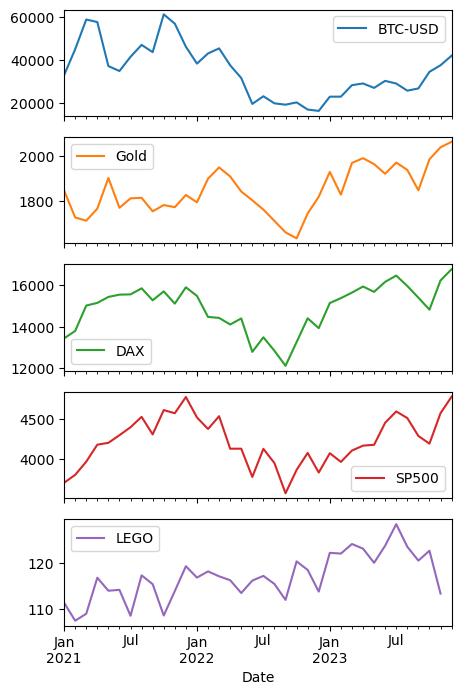

In [8477]:
all_instruments.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path / 'time_series_all.pdf')

In [8478]:
all_instruments.head()

,BTC-USD,Gold,DAX,SP500,LEGO
Date,,,,,
2021-01-31,33114.359375,1847.300049,13432.870117,3714.239990,111.371250
2021-02-28,45137.769531,1728.099976,13786.290039,3811.149902,107.491146
2021-03-31,58918.832031,1713.800049,15008.339844,3972.889893,108.990625
2021-04-30,57750.175781,1767.300049,15135.910156,4181.169922,116.781563
2021-05-31,37332.855469,1902.500000,15421.129883,4204.109863,113.975104


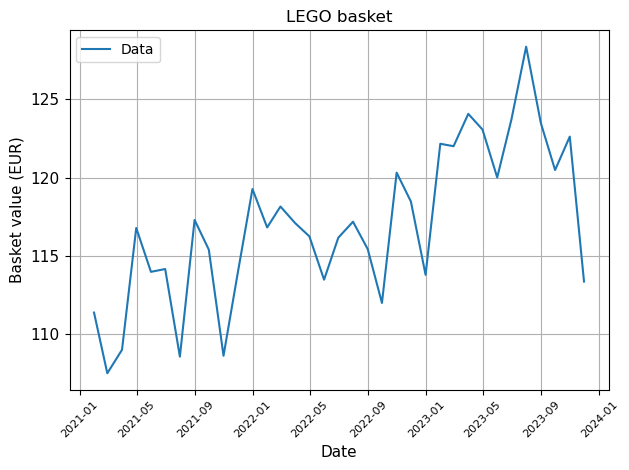

In [8479]:
# Extract x and y values from the DataFrame
x = all_instruments.index.to_numpy()
y = all_instruments['LEGO'].to_numpy()

# Plot the original data
plt.plot(x, y, label='Data')

# Show the plot without any trend line
plt.title('LEGO basket')
plt.xticks(fontsize=8)
plt.yticks(fontsize=11)
plt.ylabel('Basket value (EUR)', fontsize=11)
plt.xlabel('Date', fontsize=11)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(plots_path / 'lego_basket.pdf')
plt.show()

### **Price variability analysis over time**

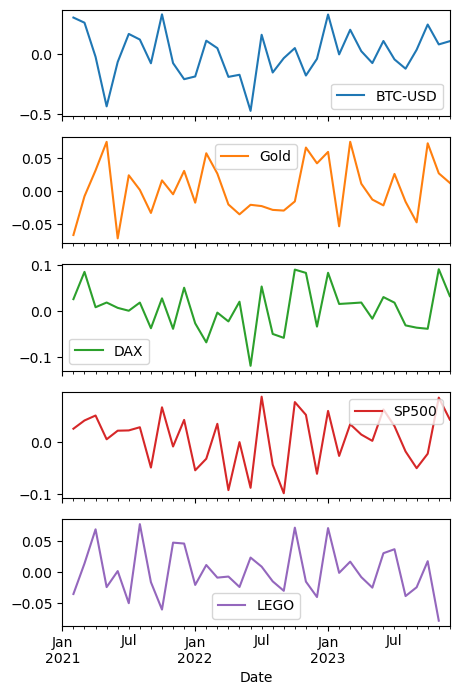

In [8480]:
# PCT change
instruments = ['BTC-USD', 'Gold', 'DAX', 'SP500', 'LEGO']
price_change = np.log(all_instruments[instruments] / all_instruments[instruments].shift(1))
price_change.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path /'price_change.pdf')

In [8481]:
# Calculate std of returns of each column
std_dev = price_change.std()
std_dev

BTC-USD    0.193572
Gold       0.040213
DAX        0.048672
SP500      0.051335
LEGO       0.039172
dtype: float64

In [8482]:
# Coefficient of Variation
COV = (all_instruments.std()/all_instruments.mean())*100
COV

BTC-USD    35.462637
Gold        5.724456
DAX         7.533373
SP500       7.115718
LEGO        4.274770
dtype: float64

Both the standard deviation and the coefficient of variation are lowest in the case of LEGO. Bitcoin, stock indexes, and even gold were more volatile during the period from 2021 to 2023.

### **Maximum Drawdown**

Maximum Drawdown (MDD) is a measure used to assess the largest single drop from peak to trough in the value of an investment portfolio or asset over a specified period. It provides insight into the potential risk and the extent of potential losses that an investor might face. 

- **Definition**: MDD is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained.
- **Calculation**: It is calculated as the difference between the highest value (peak) and the lowest value (trough) of the asset during a specified period, usually expressed as a percentage of the peak value.
$$
\text{MDD} = \frac{\text{Trough Value} - \text{Peak Value}}{\text{Peak Value}}
$$
- **Significance**: MDD helps investors understand the worst-case scenario in terms of potential losses. It is a critical measure for risk management, as it highlights the vulnerability of an asset to significant declines.
- **Interpretation**: A larger MDD indicates a higher risk, as it shows that the asset or portfolio has experienced significant losses. Conversely, a smaller MDD suggests that the asset is relatively more stable.

In [8483]:
def drawdown(price_change):
    price_change.fillna(0.0, inplace=True)
    cumulative = (price_change + 1).cumprod()
    running_max = np.maximum.accumulate(cumulative)

    return (cumulative - running_max) / running_max

/opt/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


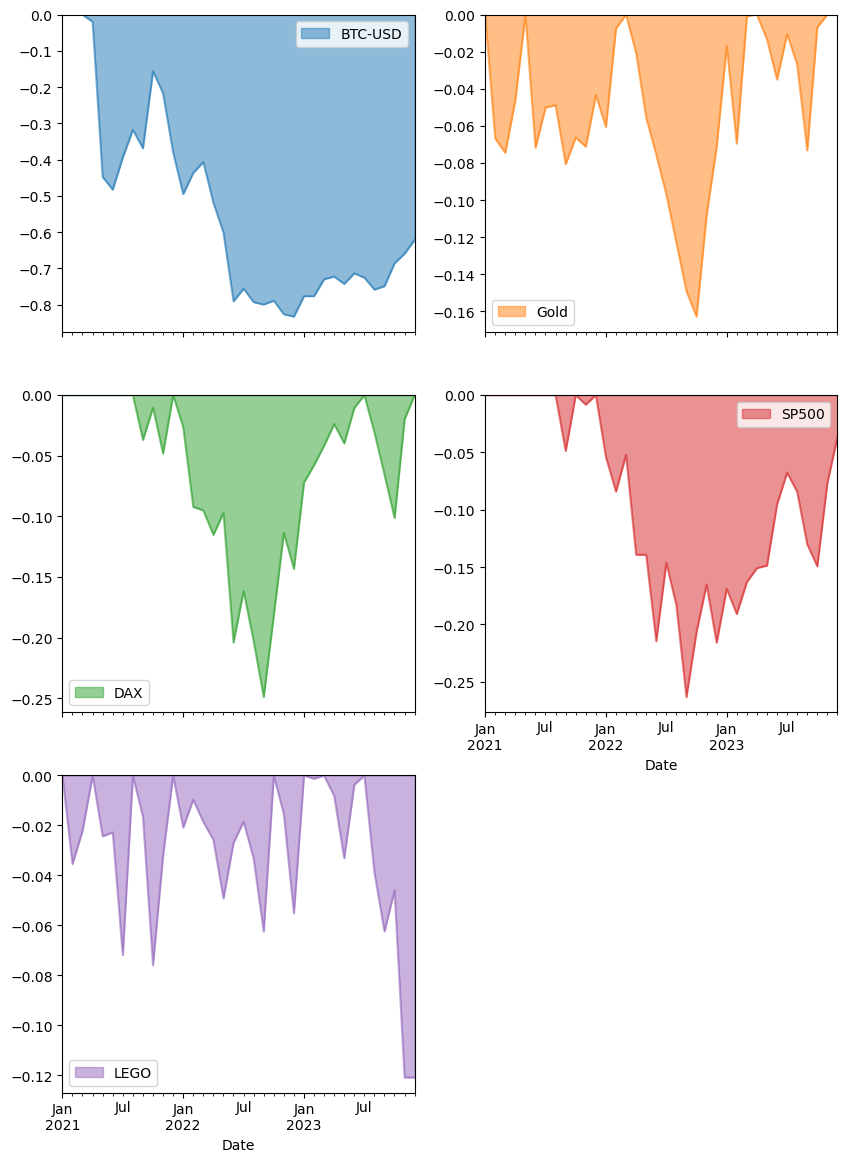

In [8484]:
drawdown(price_change).plot(kind="area", alpha=0.5, subplots=True, layout=(3, 2), figsize=(10,14))
plt.savefig(plots_path / 'max_drawdown.pdf')

In [8485]:
assets = ['BTC-USD', 'Gold', 'DAX', 'SP500', 'LEGO']
for asset in assets:
    md = np.min(drawdown(price_change[asset]))
    print(f'Maximum drawdown for {asset} was {round(np.min(drawdown(price_change[asset])), 2)}')

Maximum drawdown for BTC-USD was -0.83
Maximum drawdown for Gold was -0.16
Maximum drawdown for DAX was -0.25
Maximum drawdown for SP500 was -0.26
Maximum drawdown for LEGO was -0.12


- **Drawdown Depth**: The LEGO investment experienced maximum drawdowns reaching -12%.
- **Comparison with Other Assets**: 
  - **Bitcoin**: The MDD for Bitcoin is almost -80%, showing extreme volatility and high risk.
  - **Gold**: Gold experienced a maximum drawdown of around -16%, which is deeper than LEGO.
  - **DAX and SP500**: Both DAX and SP500 had drawdowns of approximately -25%, indicating they are more volatile and riskier compared to LEGO.

From the perspective of an investor, LEGO sets offer a compelling investment option with lower risk and volatility compared to traditional assets such as stocks, gold, and Bitcoin. The maximum drawdown analysis highlights LEGO's stability and potential as a safer investment. While the returns might not be as high as those from more volatile assets, the reduced risk of substantial financial loss makes LEGO an attractive addition to a diversified investment portfolio.

Investors seeking stability and lower risk in their investments may find LEGO sets to be a favorable choice. The collectible and timeless nature of LEGO, combined with a stable market demand, positions LEGO sets as a unique and valuable investment alternative.

### **Correlation analysis**

The correlation matrix provides insight into the relationships between different assets, including Bitcoin (BTC-USD), Gold, DAX, S&P 500 (SP500), and LEGO sets. The correlation values range from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.

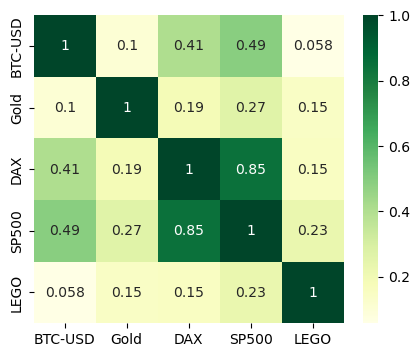

In [8486]:
# Correlation (price_change)
corr_matrix_price_change = price_change.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix_price_change, annot=True, cmap='YlGn')
plt.savefig(plots_path / 'correlation_price_change.pdf')

plt.show()

The analysis indicates that **LEGO sets are relatively independent** from traditional financial assets and Bitcoin. Their low correlation with these assets suggests that LEGO sets could serve as a unique and stable investment alternative, providing diversification benefits in an investment portfolio. This independence from other market assets can be particularly useful for investors looking to reduce risk and increase stability in their investment strategies.

### **Liquidity analysis**

Liquidity analysis is an important element of the overall LEGO sets analysis, providing insights into how quickly LEGO sets can be sold and reflecting their demand and market dynamics. However, the lack of comprehensive data available online makes this task challenging. Consequently, this analysis is limited to data from a few of the largest online marketplaces to provide an approximate view of liquidity trends.

It is important to note that this analysis does not cover sales outside of the internet, such as local sales portals or physical stores. Despite these limitations, the results derived from this analysis may still prove useful in understanding the general liquidity patterns of LEGO sets in the market.

This focused examination, even with its constraints, aims to offer valuable insights into the demand and market behavior of LEGO sets.

In [8487]:
# Average number of sales
sales_mean =float(liquidity['num_of_sales_in_2023'].dropna().mean())
print(f'Average number of sales in a year for a random set: {round(sales_mean, 2)}')

# Average time needed to sell a set
time_needed = 365 / sales_mean
print(f'Average time needed to sell a random set: {round(time_needed, 2)} days')

Average number of sales in a year for a random set: 118.49
Average time needed to sell a random set: 3.08 days


The average time needed to sell a set, which is about 3 days, signifies a relatively quick turnover. This relatively short selling period highlights the popularity, consistent demand for LEGO sets and relatively high liquidity for a physical asset - it should be noted that the analysis did not include many other possible sales channels for the sets, so the actual sale time may be even shorter.

## **Final Summary**

Overall, the analysis shows that investing in LEGO sets can be a stable and profitable option. LEGO sets have low volatility compared to other assets (even lower than gold), are relatively independent of traditional financial markets, and exhibit high liquidity. These characteristics make LEGO sets a unique and valuable addition to a diversified investment portfolio. Despite some data limitations, the results offer useful insights into the market behavior and investment potential of LEGO sets.